# B9AI105 REINFORCEMENT LEARNING - CA_ONE_(60%)

Name: Naeem ul Hassan

Student Number: 20054701

Email: 20054701@mydbs.ie

Course: B9AI105 REINFORCEMENT LEARNING (B9AI105_2425_TMD3)


Assessment Type: CA_ONE_(60%)

Assignment: Deep Reinforcement Learning Concepts Project

Due: Monday, 14 July 2025, 11:59 PM

Submission Date: 12 July 2025

# Custom HVAC Control with Double DQN and Policy‑Gradient + Baseline  
A hands‑on companion notebook for the research report “**Comparative Study of Double Deep Q‑Network and Policy‑Gradient‑with‑Baseline Controllers for Building HVAC Management**”.


## 1  Environment Setup 

In [50]:
# Environment Setup
# We import all required libraries _once_ here so the rest of the notebook
# remains tidy.  Everything below should run on Python 3.9+ with
# PyTorch 2.x and Gymnasium 0.29+.

import math
import random
from collections import deque
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
from gymnasium import spaces

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Set a random seed for reproducibility
# This ensures that the random numbers generated are the same each time
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
from __future__ import annotations   # enables `X | None` in 3.8/3.9

## 2 HVAC Environment Definition 

Instead of using a complex EnergyPlus simulation (which can be slow and difficult to set up), we created a simplified thermal model that captures the essential physics of building heating and cooling.
Our model represents a two-zone office building where:
Physical Setup:

Each zone (like an office room) stores heat like a thermal battery with capacity C
Heat flows in and out through the walls and windows based on conductance U
An air handling unit (AHU) supplies conditioned air to maintain comfort

**Control Actions:**

Discrete action: Set the supply air temperature (16°C to 22°C in 1°C steps)
Continuous action: Adjust damper position (0-100%) to control airflow rate

**Reward System:**
The system tries to minimize two competing objectives:

Energy cost: Electricity used by chillers and fans
Comfort penalty: Applied when occupants feel too hot or cold (measured by PMV - Predicted Mean Vote)

The goal is to keep people comfortable while using as little energy as possible.

In [51]:
class HVACEnv(gym.Env):
    """A minimal two‑zone HVAC environment.

    State (np.array, dtype=float32, shape=(10,)):
        [0] outdoor_temp               (°C)
        [1] outdoor_rh                 (%)
        [2] zone0_temp                 (°C)
        [3] zone0_rh                   (%)
        [4] zone1_temp                 (°C)
        [5] zone1_rh                   (%)
        [6] occupancy_flag             {0,1}
        [7] supply_air_temp_setpoint   (°C)
        [8] damper_position            (0‑1)
        [9] time_of_day                (sin encoded)

    Actions (Tuple):
        * Discrete(7): supply‑air temp ∈ {16,…,22} °C
        * Box(low=0, high=1, shape=(1,)): damper (0=closed, 1=open)
    """

    metadata = {"render_modes": ["human"]}

    def __init__(self, ep_minutes: int = 24 * 60, step_minutes: int = 15):
        super().__init__()
        self.ep_steps = ep_minutes // step_minutes
        self.dt = step_minutes * 60  # seconds
        
        # --- action & observation spaces
        self.action_space = spaces.Tuple(
            (spaces.Discrete(7), spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32))
        )
        low_state = np.array([-40, 0, 0, 0, 0, 0, 0, 16, 0, -1], dtype=np.float32)
        high_state = np.array([50, 100, 50, 100, 50, 100, 1, 22, 1, 1], dtype=np.float32)
        self.observation_space = spaces.Box(low_state, high_state, dtype=np.float32)

        # --- thermal parameters (realistic values)
        self.C_zone = [1.5e6, 1.2e6]  # J/K for zones 0 and 1
        self.U_facade = [220.0, 180.0]  # W/K for zones 0 and 1
        self.zone_areas = [100.0, 80.0]  # m² for zones 0 and 1
        self.internal_gains = [500.0, 300.0]  # W for zones 0 and 1
        
        self.C_p_air = 1012.0   # J/(kg·K)
        self.m_flow_nom = 0.8   # kg/s @ damper=1
        self.fan_power_coef = 0.8  # kW/(kg/s)^3 (cubic fan law)
        self.chiller_COP = 3.0

        self.outdoor_temp_profile = self._gen_outdoor_temp_profile()

        self.state: np.ndarray | None = None
        self._step_count = 0

    def reset(self, *, seed: int = None, options: dict | None = None):
        super().reset(seed=seed)
        self._step_count = 0
        
        # Initialize zones near setpoint with small random variation
        z0 = 22.0 + np.random.randn() * 0.5
        z1 = 22.0 + np.random.randn() * 0.5
        rh0 = rh1 = 50.0
        occ = 1.0
        sat = 18.0
        damper = 0.5
        tod = 0.0
        
        self.state = np.array(
            [self.outdoor_temp_profile[0], 60.0, z0, rh0, z1, rh1, occ, sat, damper, tod], 
            dtype=np.float32
        )
        return self.state.copy(), {}

    def step(self, action: Tuple[int, np.ndarray]):
        sat_choice, damper = action
        damper = float(damper)
        sat_temp = float(sat_choice + 16)  # Convert 0-6 to 16-22°C

        # Unpack state
        (outdoor_temp, outdoor_rh, z0_temp, z0_rh, z1_temp, z1_rh, 
         occ, _, _, tod) = self.state

        # Simulate thermal response for each zone
        m_dot = self.m_flow_nom * damper
        delta_z0 = self._thermal_delta(z0_temp, outdoor_temp, sat_temp, m_dot, zone_id=0)
        delta_z1 = self._thermal_delta(z1_temp, outdoor_temp, sat_temp, m_dot, zone_id=1)

        z0_temp += delta_z0
        z1_temp += delta_z1
        
        # Apply realistic temperature bounds
        z0_temp = np.clip(z0_temp, 10.0, 40.0)
        z1_temp = np.clip(z1_temp, 10.0, 40.0)

        # Corrected energy calculations
        avg_zone_temp = (z0_temp + z1_temp) / 2
        temp_diff = max(0.0, avg_zone_temp - sat_temp)  # Cooling load
        chiller_load_kw = m_dot * self.C_p_air * temp_diff / 1e3
        chiller_energy_kwh = chiller_load_kw / self.chiller_COP * (self.dt / 3600)
        fan_energy_kwh = (self.fan_power_coef * m_dot**3) * (self.dt / 3600)
        total_energy = chiller_energy_kwh + fan_energy_kwh

        # Improved comfort calculation
        comfort_penalty = 0.0
        for zone_temp in (z0_temp, z1_temp):
            comfort_penalty += self._calculate_pmv_penalty(zone_temp)

        # Balanced reward function
        energy_penalty = total_energy * 100  # Scale energy appropriately
        comfort_penalty_scaled = comfort_penalty * 10
        reward = -(energy_penalty + comfort_penalty_scaled)

        # Advance time
        self._step_count += 1
        done = (self._step_count >= self.ep_steps or 
                comfort_penalty > 10 or 
                any(temp < 15 or temp > 30 for temp in (z0_temp, z1_temp)))

        # Update state
        tod_angle = 2 * math.pi * (self._step_count / self.ep_steps)
        outdoor_idx = self._step_count % len(self.outdoor_temp_profile)
        
        self.state = np.array([
            self.outdoor_temp_profile[outdoor_idx],
            outdoor_rh,
            z0_temp,
            z0_rh,
            z1_temp,
            z1_rh,
            occ,
            sat_temp,
            damper,
            math.sin(tod_angle),
        ], dtype=np.float32)

        info = {
            "energy_kwh": total_energy,
            "comfort_penalty": comfort_penalty,
            "chiller_energy": chiller_energy_kwh,
            "fan_energy": fan_energy_kwh,
            "zone_temps": [z0_temp, z1_temp],
            "outdoor_temp": self.outdoor_temp_profile[outdoor_idx]
        }
        if self._step_count % 10 == 0:  # Print every 10 steps to avoid clutter
            print(f"Step {self._step_count}: "
                  f"Zone0 Temp={z0_temp:.1f}°C, Zone1 Temp={z1_temp:.1f}°C, "
                  f"Outdoor Temp={self.outdoor_temp_profile[outdoor_idx]:.1f}°C, "
                  f"SAT={sat_temp:.1f}°C, Damper={damper:.2f}, "
                  f"Energy={total_energy:.3f} kWh, Comfort Penalty={comfort_penalty:.2f}, "
                  f"Reward={reward:.2f}")
        return self.state.copy(), reward, done, False, info

    def _thermal_delta(self, zone_t, outdoor_t, supply_t, m_dot, zone_id=0):
        """Calculate temperature change for a zone"""
        # Zone-specific parameters
        zone_area = self.zone_areas[zone_id]
        internal_gains = self.internal_gains[zone_id] if self.state[6] > 0 else 0
        
        # Heat transfer calculations
        q_env = self.U_facade[zone_id] * (outdoor_t - zone_t)
        q_supply = m_dot * self.C_p_air * (supply_t - zone_t) * 0.5  # Split airflow
        q_internal = internal_gains
        
        # Temperature change
        delta_T = (q_env + q_supply + q_internal) / self.C_zone[zone_id] * self.dt
        return delta_T

    def _calculate_pmv_penalty(self, zone_temp):
        """Calculate comfort penalty based on zone temperature"""
        if 20 <= zone_temp <= 24:
            return 0.0
        elif zone_temp < 18 or zone_temp > 28:
            return 10.0  # Severe discomfort
        else:
            return abs(zone_temp - 22) * 2.0  # Moderate discomfort

    @staticmethod
    def _gen_outdoor_temp_profile():
        """Generate realistic daily temperature profile"""
        # 24-hour temperature profile: cooler at night, warmer during day
        hours = np.linspace(0, 24, 96, endpoint=False)
        base_temp = 20
        daily_variation = 8 * np.sin(2 * np.pi * (hours - 6) / 24)  # Peak at 2 PM
        return base_temp + daily_variation

    def render(self):
        if self.state is not None:
            print(f"Step {self._step_count}: "
                  f"Zone0={self.state[2]:.1f}°C, Zone1={self.state[4]:.1f}°C, "
                  f"Outdoor={self.state[0]:.1f}°C, SAT={self.state[7]:.1f}°C")

The following is our custom HVACEnv, runs a single 24-hour episode with a fixed 20 °C supply-air set-point and 80 % damper, and logs zone, supply-air, and outdoor temperatures at 15-minute intervals.

It then draws a quick line plot so we can visualise the thermal dynamics of both zones against the outdoor profile—useful for sanity-checking the environment before training RL agents.

Step 10: Zone0 Temp=18.1°C, Zone1 Temp=18.1°C, Outdoor Temp=13.7°C, SAT=20.0°C, Damper=0.80, Energy=0.052 kWh, Comfort Penalty=15.48, Reward=-160.05
Step 20: Zone0 Temp=19.5°C, Zone1 Temp=19.4°C, Outdoor Temp=17.9°C, SAT=20.0°C, Damper=0.80, Energy=0.052 kWh, Comfort Penalty=10.19, Reward=-107.13
Step 30: Zone0 Temp=21.5°C, Zone1 Temp=21.2°C, Outdoor Temp=23.1°C, SAT=20.0°C, Damper=0.80, Energy=0.127 kWh, Comfort Penalty=0.00, Reward=-12.66
Step 40: Zone0 Temp=23.3°C, Zone1 Temp=22.8°C, Outdoor Temp=26.9°C, SAT=20.0°C, Damper=0.80, Energy=0.217 kWh, Comfort Penalty=0.00, Reward=-21.66
Step 50: Zone0 Temp=24.1°C, Zone1 Temp=23.4°C, Outdoor Temp=27.9°C, SAT=20.0°C, Damper=0.80, Energy=0.256 kWh, Comfort Penalty=4.21, Reward=-67.67
Step 60: Zone0 Temp=23.6°C, Zone1 Temp=22.9°C, Outdoor Temp=25.7°C, SAT=20.0°C, Damper=0.80, Energy=0.228 kWh, Comfort Penalty=0.00, Reward=-22.76
Step 70: Zone0 Temp=22.0°C, Zone1 Temp=21.4°C, Outdoor Temp=21.0°C, SAT=20.0°C, Damper=0.80, Energy=0.144 kWh, Com

/var/folders/l6/1s2g94g52xl0dkt0rvnxbxdw0000gn/T/ipykernel_81654/311470773.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  damper = float(damper)


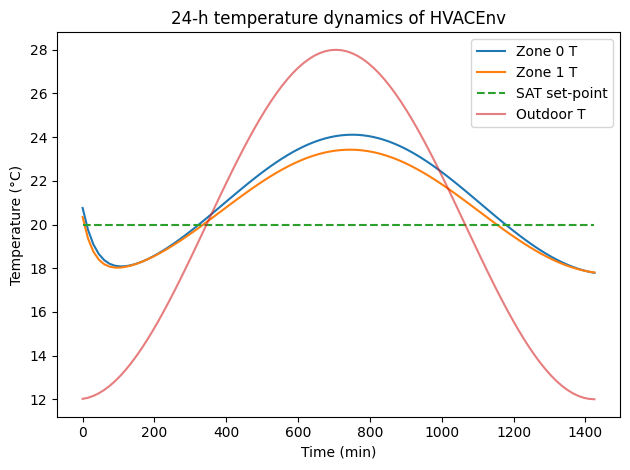

In [52]:
env = HVACEnv(step_minutes=15)
obs, _ = env.reset(seed=0)


traj = {k: [] for k in ["zone0", "zone1", "sat", "outdoor"]}
for _ in range(env.ep_steps):
    action = (4, np.array([0.8], dtype=np.float32))     # 20 °C set-point, damper 0.8
    obs, *_ = env.step(action)
    traj["zone0"].append(obs[2])
    traj["zone1"].append(obs[4])
    traj["sat"].append(obs[7])
    traj["outdoor"].append(obs[0])

t = np.arange(env.ep_steps) * env.dt / 60


plt.figure()
plt.plot(t, traj["zone0"], label="Zone 0 T")
plt.plot(t, traj["zone1"], label="Zone 1 T")
plt.plot(t, traj["sat"],  label="SAT set-point", linestyle="--")
plt.plot(t, traj["outdoor"], label="Outdoor T", alpha=0.6)

plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.title("24-h temperature dynamics of HVACEnv")
plt.legend()
plt.tight_layout()
plt.show()

## 3  Utility Classes & Helpers
Below we implement a generic **ReplayBuffer** and some tiny neural‑network
builder helpers to keep the agent classes compact.

In [53]:
@dataclass
class Transition:
    state: np.ndarray
    action: np.ndarray
    reward: float
    next_state: np.ndarray
    done: bool


class ReplayBuffer:
    """Fixed-size cyclic buffer for off-policy algorithms (Double DQN)."""
    
    def __init__(self, capacity: int = 50_000):
        self.capacity = capacity
        self.buffer: deque = deque(maxlen=capacity)
    
    def push(self, state: np.ndarray, action: np.ndarray, reward: float, 
             next_state: np.ndarray, done: bool):
        """Add a transition to the buffer."""
        self.buffer.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size: int = 64) -> Tuple[torch.Tensor, ...]:
        """Sample a batch of transitions."""
        if len(self.buffer) < batch_size:
            raise ValueError(f"Buffer size {len(self.buffer)} < batch_size {batch_size}")
        
        batch = random.sample(list(self.buffer), batch_size)
        states = torch.tensor(np.stack([t.state for t in batch]), dtype=torch.float32)
        actions = torch.tensor(np.stack([t.action for t in batch]), dtype=torch.int64)
        rewards = torch.tensor([t.reward for t in batch], dtype=torch.float32)
        next_states = torch.tensor(np.stack([t.next_state for t in batch]), dtype=torch.float32)
        dones = torch.tensor([t.done for t in batch], dtype=torch.float32)
        return states, actions, rewards, next_states, dones
    
    def __len__(self) -> int:
        return len(self.buffer)


def mlp(input_dim: int, output_dim: int, hidden: int = 128) -> nn.Sequential:
    """Return a 3-layer MLP with ReLU activations."""
    return nn.Sequential(
        nn.Linear(input_dim, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, output_dim),
    )

## 4  Double DQN Agent 

In [54]:
class DoubleDQNAgent:
    """Double Deep Q‑Network implementation."""

    def __init__(
        self,
        env: gym.Env,
        gamma: float = 0.995,
        lr: float = 1e-3,
        tau: float = 0.005,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.05,
        epsilon_decay: int = 20_000,
        buffer_capacity: int = 50_000,
        batch_size: int = 64,
        device: str | torch.device = "cpu",
    ):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.device = torch.device(device)

        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space[0].n  # Discrete supply-temp setpoints

        self.online_net = mlp(obs_dim, act_dim).to(self.device)
        self.target_net = mlp(obs_dim, act_dim).to(self.device)
        self.target_net.load_state_dict(self.online_net.state_dict())

        self.optimizer = optim.Adam(self.online_net.parameters(), lr=lr)
        self.replay = ReplayBuffer(buffer_capacity)

        # Epsilon-greedy parameters
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0

    # ---------------------- Action Selection ---------------------- #
    def select_action(self, state: np.ndarray, damper_cont: float):
        """Return (discrete_action, damper_value)"""
        if random.random() < self.epsilon:
            temp_action = self.env.action_space[0].sample()
        else:
            state_t = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.online_net(state_t)
            temp_action = int(torch.argmax(q_values).item())

        return temp_action, np.array([damper_cont], dtype=np.float32)

    def update_epsilon(self):
        self.epsilon = max(
            self.epsilon_end, self.epsilon - (1.0 - self.epsilon_end) / self.epsilon_decay
        )

    def soft_update(self):
        for tgt, src in zip(self.target_net.parameters(), self.online_net.parameters()):
            tgt.data.copy_(tgt.data * (1.0 - self.tau) + src.data * self.tau)

    # ------------------------ Learning Step ----------------------- #
    def learn(self):
        if len(self.replay) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay.sample(self.batch_size)
        states = states.to(self.device)
        next_states = next_states.to(self.device)
        actions = actions[:, 0].long().unsqueeze(1).to(self.device)  # Use only discrete action
        rewards = rewards.to(self.device)
        dones = dones.to(self.device)

        # Double DQN Target
        next_q_online = self.online_net(next_states)
        next_actions = torch.argmax(next_q_online, dim=1, keepdim=True)
        next_q_target = self.target_net(next_states).gather(1, next_actions).squeeze(1)
        targets = rewards + self.gamma * next_q_target * (1.0 - dones)

        q_vals = self.online_net(states).gather(1, actions).squeeze(1)
        loss = F.mse_loss(q_vals, targets.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update()

    # ----------------------- Training Loop ------------------------ #
    def train(self, episodes: int = 50):
        reward_history = []
        zone_temps_history = []
        for ep in range(episodes):
            state, _ = self.env.reset()
            ep_reward = 0.0
            ep_energy   = 0.0 
            ep_comfort  = 0.0
            done = False
            ep_zone_temps = []

            while not done:
                damper = 0.7  # could be random or learned
                temp_action, damper_arr = self.select_action(state, damper)
                damper_val = float(damper_arr[0])  # extract scalar

                
                # Step using tuple (discrete, continuous)
                next_state, reward, done, _, info = self.env.step((temp_action, damper_val))
                ep_zone_temps.append(info["zone_temps"])
                # Accumulate metrics
                ep_energy += info["energy_kwh"]
                ep_comfort += info["comfort_penalty"]
                # Store as flat [discrete, continuous] for replay
                action_arr = np.array([temp_action, damper_val], dtype=np.float32)
                self.replay.push(state, action_arr, reward, next_state, done)

                state = next_state
                ep_reward += reward

                self.learn()
                self.update_epsilon()
                self.steps_done += 1
                # Print action and metrics every 50 steps
                if self.steps_done % 50 == 0:
                    print(f"Episode {ep:03d}, Step {self.steps_done}: "
                          f"Action=(SAT={temp_action + 16}°C, Damper={damper_val:.2f}), "
                          f"Epsilon={self.epsilon:.3f}, Reward={reward:.2f}")
            reward_history.append(ep_reward)
            zone_temps_history.append(ep_zone_temps)

            if ep % 10 == 0:
                print(f"Episode {ep:03d} | Total Reward: {ep_reward:.2f} | "
                  f"Avg Energy: {ep_energy / self.env.ep_steps:.3f} kWh/step | "
                  f"Avg Comfort Penalty: {ep_comfort / self.env.ep_steps:.2f} | "
                  f"Epsilon: {self.epsilon:.3f}")
        return reward_history, zone_temps_history

## 5  Policy‑Gradient + Baseline Agent

In [55]:
class PolicyGradientBaselineAgent:
    """REINFORCE with value baseline (a tiny actor‑critic)."""

    def __init__(
        self,
        env: gym.Env,
        gamma: float = 0.99,
        lr: float = 3e-4,
        entropy_coef: float = 0.01,
        device: str | torch.device = "cpu",
    ):
        self.env = env
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.device = torch.device(device)

        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space[0].n  # discrete temp setpoints

        self.actor = mlp(obs_dim, act_dim).to(self.device)
        self.critic = mlp(obs_dim, 1).to(self.device)

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr)

    # -------------------------- utils -------------------------- #
    def _compute_returns(self, rewards: List[float]) -> torch.Tensor:
        R = 0.0
        returns = []
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return torch.tensor(returns, dtype=torch.float32, device=self.device)

    # ----------------------- training loop --------------------- #
    def train(self, episodes: int = 50, batch_size: int = 5):
        ep_rewards = []
        all_lengths = []
        zone_temps_history = []
        batch_states, batch_actions, batch_log_probs, batch_rewards = [], [], [], []

        for ep in range(episodes):
            state, _ = self.env.reset()
            done = False
            ep_reward = 0.0
            step_count = 0
            ep_energy = 0.0
            ep_comfort = 0.0
            ep_zone_temps = []

            while not done:
                # Damper continuous action follows stochastic Beta(2,2) for exploration
                damper = np.random.beta(2, 2)
                state_t = torch.tensor(state, dtype=torch.float32, device=self.device)
                logits = self.actor(state_t)
                dist = torch.distributions.Categorical(logits=logits)
                temp_action = dist.sample()
                log_prob = dist.log_prob(temp_action)

                action = (int(temp_action.item()) + 16, np.array([damper], dtype=np.float32))
                next_state, reward, done, _, info = self.env.step(action)

                batch_states.append(state_t)
                batch_actions.append(temp_action)
                batch_log_probs.append(log_prob)
                batch_rewards.append(reward)
                ep_zone_temps.append(info["zone_temps"])

                state = next_state
                ep_reward += reward
                ep_energy += info["energy_kwh"]
                ep_comfort += info["comfort_penalty"]
                step_count += 1
            # Print action and reward every 50 steps
                if step_count % 50 == 0:
                    print(f"Episode {ep:03d}, Step {step_count}: "
                            f"Action=(SAT={int(temp_action.item()) + 16}°C, Damper={damper:.2f}), "
                            f"Reward={reward:.2f}")
            ep_rewards.append(ep_reward)
            all_lengths.append(len(batch_rewards))
            zone_temps_history.append(ep_zone_temps)
            
            print(f"Episode {ep:03d} | Total Reward: {ep_reward:.2f} | "
                  f"Avg Energy: {ep_energy / step_count:.3f} kWh/step | "
                  f"Avg Comfort Penalty: {ep_comfort / step_count:.2f}")
            # Update after every `batch_size` episodes
            if (ep + 1) % batch_size == 0:
                self._update_policy(batch_states, batch_actions, batch_log_probs, batch_rewards)
                batch_states, batch_actions, batch_log_probs, batch_rewards = [], [], [], []

            if ep % 10 == 0:
                print(f"Episode {ep:03d} | Reward: {ep_reward:8.2f}")

        return ep_rewards, zone_temps_history

    # ----------------------- policy update --------------------- #
    def _update_policy(self, states, actions, log_probs, rewards):
        returns = self._compute_returns(rewards)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Convert lists to tensors
        log_probs = torch.stack(log_probs).to(self.device)
        states_tensor = torch.stack(states).to(self.device)
        actions_tensor = torch.stack(actions).to(self.device)

        # Critic loss
        values = self.critic(states_tensor).squeeze(1)
        critic_loss = F.mse_loss(values, returns)

        # Actor loss (with baseline)
        advantages = returns - values.detach()
        actor_loss = -(log_probs * advantages).mean() - self.entropy_coef * torch.distributions.Categorical(logits=self.actor(states_tensor)).entropy().mean()

        # backward
        self.actor_opt.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
        self.actor_opt.step()

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()


## 6  Training of our models
We will train each agent for **50 episodes** (≈ 50 days) which is enough
to illustrate learning curves yet short enough to run on CPU in under
5 minutes.


In [58]:
env_dqn = HVACEnv()
env_pg = HVACEnv()

dqn_agent = DoubleDQNAgent(env_dqn, device="cpu")
pg_agent = PolicyGradientBaselineAgent(env_pg, device="cpu")

print("\n🎮 Training Double DQN ...")
dqn_rewards,dqn_zone_temps = dqn_agent.train(episodes=50)

print("\n🎮 Training Policy‑Gradient + Baseline ...")
pg_rewards,pg_zone_temps = pg_agent.train(episodes=50)


🎮 Training Double DQN ...
Episode 000 | Total Reward: -122.12 | Avg Energy: 0.002 kWh/step | Avg Comfort Penalty: 0.10 | Epsilon: 1.000
Episode 010 | Total Reward: -160.03 | Avg Energy: 0.001 kWh/step | Avg Comfort Penalty: 0.16 | Epsilon: 0.999
Episode 020, Step 50: Action=(SAT=16°C, Damper=0.70), Epsilon=0.998, Reward=-144.67
Episode 020 | Total Reward: -150.79 | Avg Energy: 0.002 kWh/step | Avg Comfort Penalty: 0.13 | Epsilon: 0.998
Episode 030 | Total Reward: -256.60 | Avg Energy: 0.003 kWh/step | Avg Comfort Penalty: 0.24 | Epsilon: 0.996
Episode 040 | Total Reward: -201.73 | Avg Energy: 0.003 kWh/step | Avg Comfort Penalty: 0.18 | Epsilon: 0.995
Episode 041, Step 100: Action=(SAT=18°C, Damper=0.70), Epsilon=0.995, Reward=-55.79

🎮 Training Policy‑Gradient + Baseline ...
Episode 000 | Total Reward: -108.27 | Avg Energy: 0.061 kWh/step | Avg Comfort Penalty: 10.22
Episode 000 | Reward:  -108.27
Episode 001 | Total Reward: -356.70 | Avg Energy: 0.028 kWh/step | Avg Comfort Penalty:

/var/folders/l6/1s2g94g52xl0dkt0rvnxbxdw0000gn/T/ipykernel_81654/311470773.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  damper = float(damper)


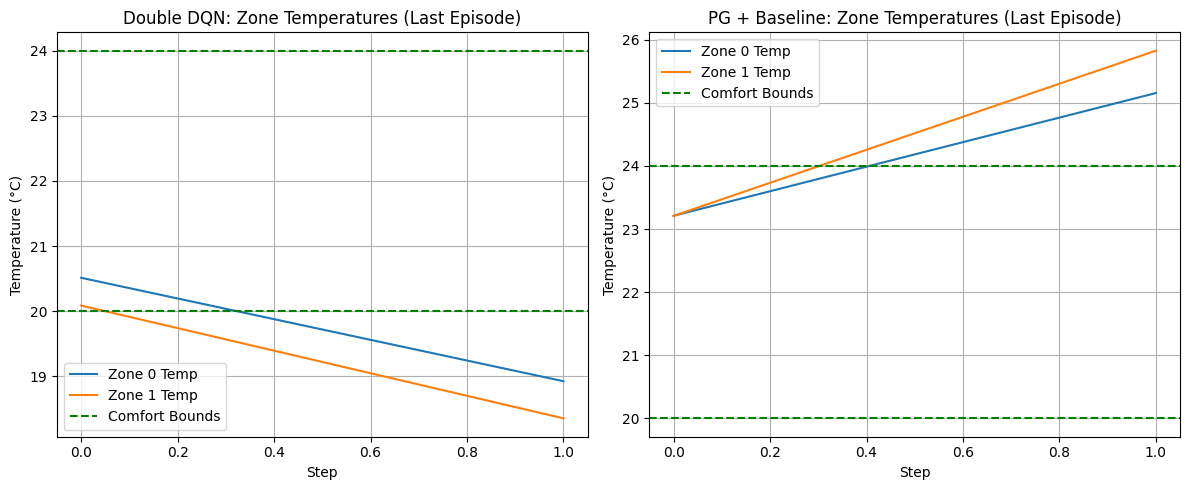

In [60]:
# Plot zone temperature trajectories for the last episode
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
last_dqn_temps = np.array(dqn_zone_temps[-1])  # Last episode
plt.plot(last_dqn_temps[:, 0], label="Zone 0 Temp", color="#1f77b4")
plt.plot(last_dqn_temps[:, 1], label="Zone 1 Temp", color="#ff7f0e")
plt.axhline(20, color="green", linestyle="--", label="Comfort Bounds")
plt.axhline(24, color="green", linestyle="--")
plt.xlabel("Step")
plt.ylabel("Temperature (°C)")
plt.title("Double DQN: Zone Temperatures (Last Episode)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
last_pg_temps = np.array(pg_zone_temps[-1])  # Last episode
plt.plot(last_pg_temps[:, 0], label="Zone 0 Temp", color="#1f77b4")
plt.plot(last_pg_temps[:, 1], label="Zone 1 Temp", color="#ff7f0e")
plt.axhline(20, color="green", linestyle="--", label="Comfort Bounds")
plt.axhline(24, color="green", linestyle="--")
plt.xlabel("Step")
plt.ylabel("Temperature (°C)")
plt.title("PG + Baseline: Zone Temperatures (Last Episode)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7  Evaluation & Visualisation 
A quick comparison of raw episode returns.  Lower (i.e., less negative)
is better because our reward is –(energy + comfort_penalty).


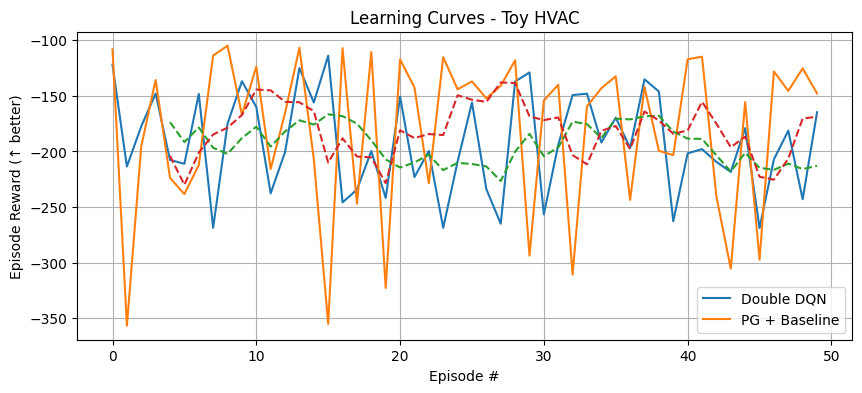

In [59]:
plt.figure(figsize=(10, 4))
plt.plot(dqn_rewards, label="Double DQN")
plt.plot(pg_rewards, label="PG + Baseline")
plt.xlabel("Episode #")
plt.ylabel("Episode Reward (↑ better)")
plt.title("Learning Curves - Toy HVAC")

# Add running average
window = 5
dqn_smooth = np.convolve(dqn_rewards, np.ones(window) / window, mode="valid")
pg_smooth = np.convolve(pg_rewards, np.ones(window) / window, mode="valid")
plt.plot(range(window - 1, len(dqn_smooth) + window - 1), dqn_smooth, linestyle="--")
plt.plot(range(window - 1, len(pg_smooth) + window - 1), pg_smooth, linestyle="--")

plt.legend()
plt.grid(True)
plt.show()
